In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

2022-05-29 19:51:54.168470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-29 19:51:54.168502: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
fileName = "Bitstamp_BTCUSD_2022_minute.csv"


In [3]:
df = pd.read_csv(fileName)
pd.DataFrame(df).shape
df

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1653610740,2022-05-27 00:19:00,BTC/USD,29241.41,29253.22,29241.41,29253.22,0.392701,11487.783081
1,1653610680,2022-05-27 00:18:00,BTC/USD,29252.98,29253.23,29228.16,29241.41,0.129137,3776.159075
2,1653610620,2022-05-27 00:17:00,BTC/USD,29281.81,29286.13,29257.71,29267.22,0.062760,1836.812776
3,1653610560,2022-05-27 00:16:00,BTC/USD,29224.36,29291.15,29222.86,29274.80,0.219500,6425.818893
4,1653610500,2022-05-27 00:15:00,BTC/USD,29226.61,29244.80,29200.85,29244.80,0.062912,1839.850027
...,...,...,...,...,...,...,...,...,...
205416,1640995500,2022-01-01 00:05:00,BTC/USD,46305.36,46431.25,46303.04,46431.25,2.556501,118701.524984
205417,1640995440,2022-01-01 00:04:00,BTC/USD,46326.81,46326.81,46289.56,46289.56,4.159950,192562.242161
205418,1640995380,2022-01-01 00:03:00,BTC/USD,46359.84,46386.33,46319.86,46342.63,0.098252,4553.263034
205419,1640995320,2022-01-01 00:02:00,BTC/USD,46310.02,46370.36,46276.28,46370.36,0.545551,25297.389313


In [4]:
def readCSV(file):
    df = pd.read_csv(file,usecols = ["unix","high","low","open","Volume BTC","Volume USD","close"])
    df.rename(columns={'unix': 'time', 'Volume BTC': 'volumeto', 'Volume USD': 'volumefrom'}, inplace=True)

    titles = ["time","high" ,"low","open" ,"volumefrom","volumeto" ,"close"]

    df = df[titles]

    df = df.set_index('time')
    df.index = pd.to_datetime(df.index, unit='s')
    
    return df.iloc[::-1]

In [5]:
hist = readCSV(fileName)
target_col = 'close'
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-01-01 00:01:00,46278.36,46199.90,46218.47,8961.351812,0.193640,46278.36
2022-01-01 00:02:00,46370.36,46276.28,46310.02,25297.389313,0.545551,46370.36
2022-01-01 00:03:00,46386.33,46319.86,46359.84,4553.263034,0.098252,46342.63
2022-01-01 00:04:00,46326.81,46289.56,46326.81,192562.242161,4.159950,46289.56
2022-01-01 00:05:00,46431.25,46303.04,46305.36,118701.524984,2.556501,46431.25
...,...,...,...,...,...,...
2022-05-27 00:15:00,29244.80,29200.85,29226.61,1839.850027,0.062912,29244.80
2022-05-27 00:16:00,29291.15,29222.86,29224.36,6425.818893,0.219500,29274.80
2022-05-27 00:17:00,29286.13,29257.71,29281.81,1836.812776,0.062760,29267.22


In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(hist, test_size=0.1)

In [8]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

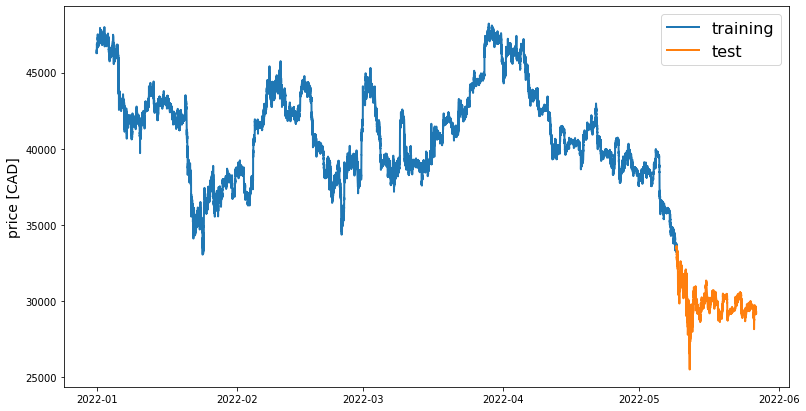

In [9]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [10]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [11]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [12]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.1):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [13]:
def build_lstm_model(input_data, output_size, neurons=300, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [14]:
np.random.seed(42)
window_len = 5
test_size = 0.1
zero_base = True
lstm_neurons = 300
epochs = 50
batch_size = 36
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [15]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [17]:
print(X_test)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
print(type(model))
print(type(history))
print(type(history.history))

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.06066959e-03  1.06066959e-03  1.06066959e-03 -9.90453974e-02
   -1.00000000e-01  1.06066959e-03]
  [ 1.18275676e-03  6.80412690e-04  1.18275676e-03  1.62395253e+02
    1.62215720e+02  1.09997570e-03]
  [ 1.08985140e-04  1.08091819e-04  1.08985140e-04  3.75407435e+01
    3.75365780e+01  1.08091819e-04]
  [ 5.31525887e-04  5.31525887e-04  5.31525887e-04  5.31525887e-04
    0.00000000e+00  5.31525887e-04]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.21957822e-04 -3.79853996e-04  1.21957822e-04  1.80357921e+02
    1.80350800e+02  3.92644694e-05]
  [-9.50676093e-04 -9.51568467e-04 -9.50676093e-04  4.17776753e+01
    4.18184200e+01 -9.51568467e-04]
  [-5.28583046e-04 -5.28583046e-04 -5.28583046e-04  1.10523797e-01
    1.11111111e-01 -5.28583046e-04]
  [-1.22076805e-03 -1.54023805e-03 -1.22076805e-03  1.21076298e+00
    

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)
print(type(targets))
print(type(preds))
mean_absolute_error(preds, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)